In [33]:
from ptlpinns.odes import numerical
import numpy as np
import matplotlib.pyplot as plt
import time

In [34]:
N_ITER = 500

### Define time domain

In [35]:
Nx = 200
x_span = (0, 2) 
Nt = 100
t_span = (0, 5)

x = np.linspace(x_span[0], x_span[1], Nx)
t = np.linspace(t_span[0], t_span[1], Nt)
mesh_x, mesh_t = np.meshgrid(x, t)

### Equation parameters

In [36]:
# KPP Fisher
epsilons = [0.5]
D = 0.05 

def u_0_function(x):
    return np.sin(np.pi * x / 2)

u_0 = [u_0_function for _ in range(len(epsilons))]  
forcing = [lambda x, t: 0 for _ in range(len(epsilons))] 
bcs = [[lambda t: 0, lambda t: 0] for _ in range(len(epsilons))]  
polynomial = [lambda u: -u + u**2 for _ in range(len(epsilons))]

result = numerical.solution_KPP(epsilons, D, polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs).squeeze()
result = result.swapaxes(0, 1) 

In [37]:
def plot_solution_PDE(solution, mesh_x, mesh_t, surface=True, title=None, rotation=(25, -60),save_name=None, path=None):
    """
    args:
        solution (np.ndarray): shape (Nx, Nt) or (Nt, Nx)
        mesh_x, mesh_t (np.ndarray): meshgrids of size (Nx, Nt)
        surface (bool): True for 3D surface plot, False for contourf
        path (str): path to save the figure
        title (str): title of the plot
        rotation (tuple): (elev, azim) for 3D view
    """
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d' if surface else None)

    if surface:
        ax.plot_surface(mesh_x, mesh_t, solution, cmap='viridis')
        ax.view_init(rotation[0], rotation[1])
        ax.set_xlabel("$x$", fontsize=13)
        ax.set_ylabel("$t$", fontsize=13)
        ax.set_zlabel("u", fontsize=13)
        plt.tick_params(axis='both', which='major', labelsize=14)

    else:
        min_level = solution.min() 
        levels = np.linspace(min_level, solution.max(), 20)
        Cs = ax.contourf(mesh_x, mesh_t, solution, levels=levels, extend="min")
        cbar = fig.colorbar(Cs)
        new_ticks = np.linspace(min_level, solution.max(), 20)[::2]
        cbar.set_ticks(new_ticks)
        cbar.ax.tick_params(labelsize=12)
        ax.set_xlabel("$x$", fontsize=16)
        ax.set_ylabel("$t$", fontsize=16)

    

    if save_name is not None:
        plt.savefig(f"{save_name}.pdf", bbox_inches="tight")
    plt.show()


In [38]:
def kpp_fisher_u0(x, t, L, D):
    """
    0th-order (ε=0) solution of Fisher-KPP on (0,L) with Dirichlet BCs
    and initial condition u(x,0) = sin(pi * x / L).

    Args:
        x (array_like): spatial points in [0, L]
        t (float or array_like): time(s) >= 0
        L (float): domain length > 0
        D (float): diffusivity > 0

    Returns:
        np.ndarray: u(x,t) with broadcasting over x and t
    """

    decay = np.exp(-D * (np.pi / L)**2 * t)
    return decay * np.sin(np.pi * x / L)

kpp_fisher_0th_order = kpp_fisher_u0(mesh_x, mesh_t, 2, 0.05)

In [39]:
result.shape

(100, 200)

In [40]:
kpp_fisher_0th_order.shape

(100, 200)

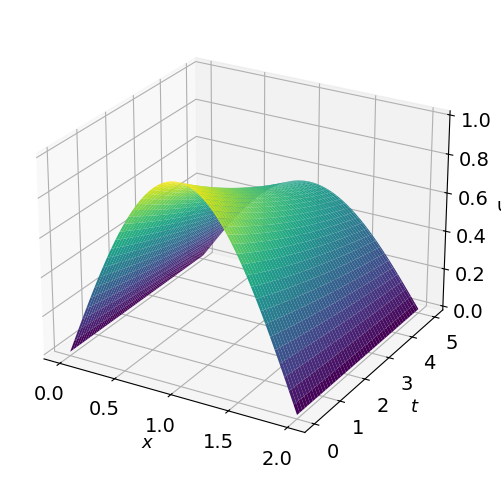

In [45]:
plot_solution_PDE(kpp_fisher_0th_order, mesh_x, mesh_t, surface=True)

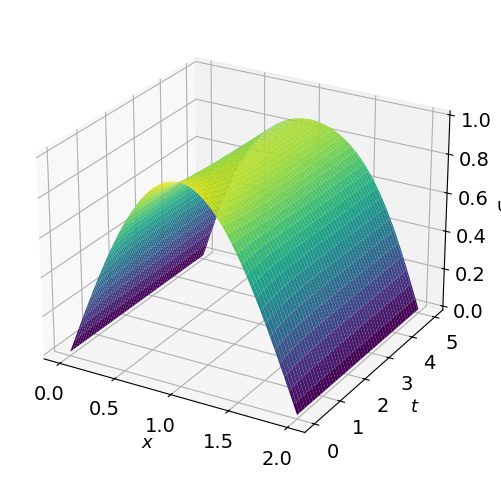

In [44]:
plot_solution_PDE(result, mesh_x, mesh_t, surface=True)

In [43]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import multihead_model_bcT as multihead

# Paramètres
c = 1.0            # vitesse de propagation
Nx = 100           # nombre de points spatiaux
x_span = (0, 2)
x = np.linspace(*x_span, Nx)
dx = x[1] - x[0]

# Conditions initiales
u0 = np.ones_like(x) - 0.5*x#np.ones_like(x) + 2*x*(2-x)#np.sin(np.pi*x)        # profil initial
v0 = np.ones_like(x)       # vitesse initiale u_t(x,0)=0
U0 = np.concatenate([u0, v0])

# Temps
Nt = 100
t_span = (0, 5)
t_eval = np.linspace(*t_span, Nt)

# Fonction source (ici 0)
def f(x, t):
    return 0

# RHS du système
def rhs_wave(t, U):
    u = U[:Nx]
    v = U[Nx:]
    # conditions aux bords sur u
    u[0] = 1
    u[-1] = 0
    # 2nd dérivée en x
    d2udx2 = np.zeros_like(u)
    d2udx2[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
    # on pourrait imposer Neumann à la place, etc.
    du_dt = v
    dv_dt = c**2 * d2udx2 + f(x, t)
    return np.concatenate([du_dt, dv_dt])

# Résolution
sol = solve_ivp(rhs_wave, t_span, U0, t_eval=t_eval, method='RK45')
# Reconstruction de la solution
U = sol.y
solution = U[:Nx, :]
# Visualisation

mesh_x, mesh_t = np.meshgrid(x, t_eval)
print(mesh_x.shape, mesh_t.shape)

# print(sol.y[500:1000,:].shape)
multihead.plot_solution1(solution, mesh_x, mesh_t, title='linear solution', surface = True)
multihead.plot_solution1(solution, mesh_x, mesh_t, title='linear solution', surface = False)
# multihead.plot_solution1(error, mesh_x, mesh_t, title='error', surface = False)

ModuleNotFoundError: No module named 'multihead_model_bcT'

In [ ]:
total_RK45, total_Radau = [], []


for j in range(N_ITER):

    start_RK45 = time.perf_counter()
    
    end_RK45 = time.perf_counter()

        start_Radau = time.perf_counter()
        numerical.solve_ode_equation(ode, t_span, t_eval, ic_list[i], method="Radau", rtol=1e-5, atol=1e-5)[0]
        end_Radau = time.perf_counter()

        RK45_time_list.append(end_RK45 - start_RK45)
        Radau_time_list.append(end_Radau - start_Radau)

    total_RK45.append(RK45_time_list)
    total_Radau.append(Radau_time_list)

    Radau_time.append(np.mean(RK45_time_list[i]))
    RK45_time.append(np.mean(Radau_time_list[i]))

IndentationError: unexpected indent (181284149.py, line 4)